In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('spx.csv')

In [3]:
df.head()

,date,close
0,02-Jan-86,209.59
1,03-Jan-86,210.88
2,06-Jan-86,210.65
3,07-Jan-86,213.80
4,08-Jan-86,207.97


In [4]:
df.shape

(8192, 2)

In [5]:
 df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [6]:
df

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97
...,...
2018-06-25,2717.07
2018-06-26,2723.06
2018-06-27,2699.63


In [7]:
df.shape

(8192, 1)

In [8]:
import matplotlib.pyplot as plt

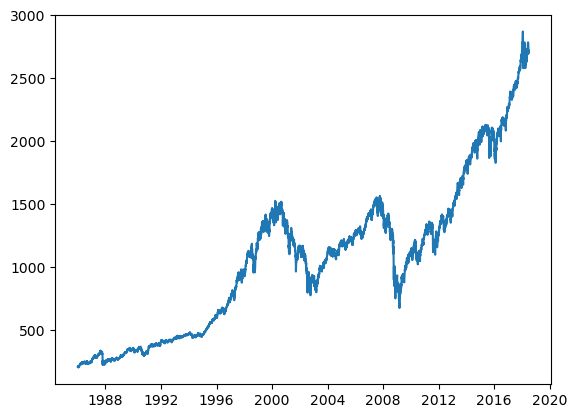

In [9]:
plt.plot(df,label='close price')

In [10]:
#splitting data set
train_size=int(len(df)*0.95)
test_size=len(df)-train_size
train,test=df.iloc[0:train_size,:],df.iloc[train_size:len(df):1]



In [11]:
train_size,test_size

(7782, 410)

In [12]:
train.shape

(7782, 1)

In [13]:
test.shape

(410, 1)

In [14]:
import numpy as np

In [15]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
sacler=scaler.fit(train[['close']])


In [16]:
train['close']=scaler.transform(train[['close']])
test['close']=scaler.transform(test[['close']])

/Users/muskanchoudhary/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/muskanchoudhary/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
train.head()

,close
date,
1986-01-02,-1.475126
1986-01-03,-1.472703
1986-01-06,-1.473135
1986-01-07,-1.467219
1986-01-08,-1.478169


In [18]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [19]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 30
X_train, y_train = create_dataset(train[['close']],train.close,time_step)
X_test, ytest = create_dataset(test[['close']],test.close,time_step)


In [20]:
print(X_train.shape), print(y_train.shape)

(7752, 30, 1)
(7752,)


(None, None)

In [21]:
train.close

date
1986-01-02   -1.475126
1986-01-03   -1.472703
1986-01-06   -1.473135
1986-01-07   -1.467219
1986-01-08   -1.478169
                ...   
2016-11-04    2.047774
2016-11-07    2.134814
2016-11-08    2.149916
2016-11-09    2.194431
2016-11-10    2.202357
Name: close, Length: 7782, dtype: float64

In [22]:
print(X_test.shape),print(ytest.shape)

(380, 30, 1)
(380,)


(None, None)

In [23]:
import tensorflow as tf

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout,RepeatVector,TimeDistributed

In [25]:
model = Sequential()
model.add(LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(n=X_train.shape[1]))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(
  TimeDistributed(
    Dense(units=X_train.shape[2])
  )
)

model.compile(loss='mae', optimizer='adam')
model.summary()

2022-09-04 17:51:03.454312: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-04 17:51:03.455684: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
____________________________________________________

In [26]:
pip install -U numpy==1.18.5

Note: you may need to restart the kernel to use updated packages.


In [27]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
#     we dont want our data to shuffle in time series never
    shuffle=False)

Train on 6976 samples, validate on 776 samples
Epoch 1/10


2022-09-04 17:51:06.914232: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_5287_5758' and '__inference___backward_standard_lstm_5287_5758_specialized_for_StatefulPartitionedCall_1_at___inference_distributed_function_5856' both implement 'lstm_eb79bb22-7549-4e7f-a52b-8ac425ea91e0' but their signatures do not match.


6944/6976 [============================>.] - ETA: 0s - loss: 0.1641

2022-09-04 17:51:35.351374: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_6483' and '__inference_standard_lstm_6483_specialized_for_sequential_lstm_StatefulPartitionedCall_at___inference_distributed_function_7293' both implement 'lstm_d153e8a3-705d-40c9-8e29-59362de56d63' but their signatures do not match.


6976/6976 [==============================] - 32s 5ms/sample - loss: 0.1641 - val_loss: 0.1917
Epoch 2/10
6976/6976 [==============================] - 27s 4ms/sample - loss: 0.0890 - val_loss: 0.1927
Epoch 3/10
6976/6976 [==============================] - 28s 4ms/sample - loss: 0.0956 - val_loss: 0.0853
Epoch 4/10
6976/6976 [==============================] - 28s 4ms/sample - loss: 0.0887 - val_loss: 0.1049
Epoch 5/10
6976/6976 [==============================] - 33s 5ms/sample - loss: 0.0915 - val_loss: 0.0893
Epoch 6/10
6976/6976 [==============================] - 37s 5ms/sample - loss: 0.1116 - val_loss: 0.0689
Epoch 7/10
6976/6976 [==============================] - 44s 6ms/sample - loss: 0.1073 - val_loss: 0.0982
Epoch 8/10
6976/6976 [==============================] - 47s 7ms/sample - loss: 0.1084 - val_loss: 0.0582
Epoch 9/10
6976/6976 [==============================] - 35s 5ms/sample - loss: 0.1057 - val_loss: 0.0684
Epoch 10/10
6976/6976 [==============================] - 44s 6ms/s

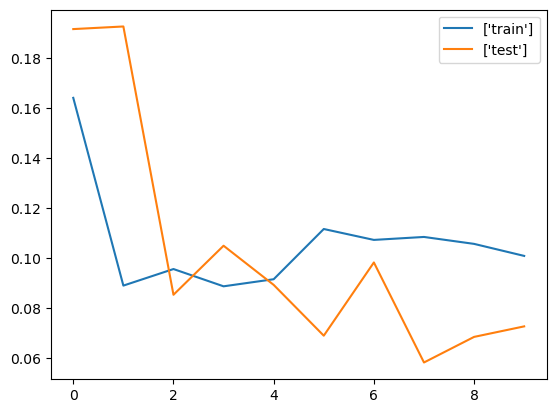

In [28]:
plt.plot(history.history['loss'],label=['train'])
plt.plot(history.history['val_loss'],label=['test'])
plt.legend();

In [29]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

2022-09-04 17:57:01.034969: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_11979' and '__inference_standard_lstm_11979_specialized_for_sequential_lstm_StatefulPartitionedCall_at___inference_distributed_function_12760' both implement 'lstm_5da1b85d-040a-4daf-b8ad-a3ab14c4ea5f' but their signatures do not match.


In [30]:
import seaborn as sns

/Users/muskanchoudhary/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

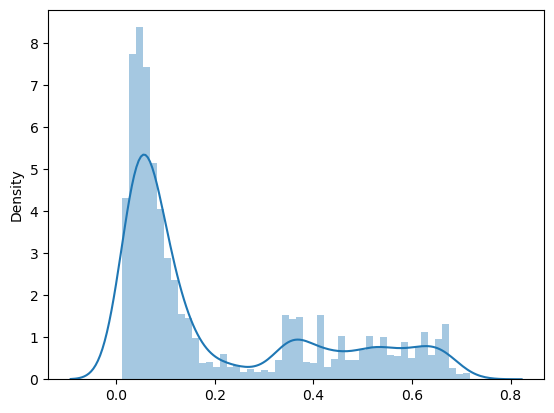

In [31]:
sns.distplot(train_mae_loss,bins=50,kde=True)

In [32]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [33]:
test_mae_loss

array([[0.10350864],
       [0.10198161],
       [0.10257082],
       [0.10404145],
       [0.10883998],
       [0.10866039],
       [0.10188102],
       [0.0999469 ],
       [0.09301003],
       [0.09417337],
       [0.0956948 ],
       [0.09474287],
       [0.09693108],
       [0.10025372],
       [0.10345681],
       [0.10530883],
       [0.10804909],
       [0.10609391],
       [0.10589158],
       [0.10123547],
       [0.08292233],
       [0.07817201],
       [0.07758527],
       [0.0838673 ],
       [0.09299315],
       [0.09748172],
       [0.10053949],
       [0.09095603],
       [0.09243954],
       [0.08906205],
       [0.09181802],
       [0.08445255],
       [0.07858005],
       [0.0783027 ],
       [0.07876288],
       [0.08608219],
       [0.09188624],
       [0.09539848],
       [0.10455114],
       [0.10624605],
       [0.10807197],
       [0.1088199 ],
       [0.11053917],
       [0.10849169],
       [0.11503919],
       [0.1160599 ],
       [0.11613734],
       [0.116

In [39]:
THRESHOLD=0.4
test_score_df = pd.DataFrame(index=test[time_step:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_step:].close

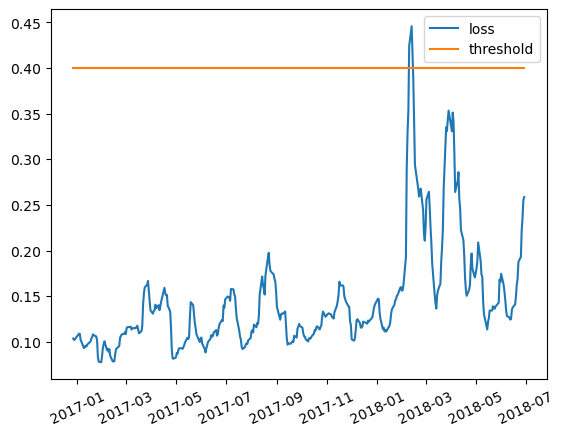

In [40]:
plt.plot(test_score_df.index,test_score_df.loss,label='loss')
plt.plot(test_score_df.index,test_score_df.threshold,label='threshold')
plt.xticks(rotation=25)
plt.legend()

In [41]:
anomalies = test_score_df[test_score_df.anomaly == True]

In [42]:
anomalies

,loss,threshold,anomaly,close
date,,,,
2018-02-09,0.424226,0.4,True,3.051476
2018-02-12,0.445839,0.4,True,3.119939
2018-02-13,0.417840,0.4,True,3.132975


In [43]:
plt.plot(
  test[time_step:].index, 
  scaler.inverse_transform(test[time_step:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();


ValueError: Expected 2D array, got 1D array instead:
array=[2.39281599 2.35720362 2.35596395 2.33637339 2.37206089 2.39632839
 2.39304138 2.40803013 2.39285355 2.39285355 2.40491217 2.39574612
 2.40363494 2.39095648 2.39846964 2.38306767 2.39738023 2.38590388
 2.41383405 2.44820674 2.44503243 2.44129464 2.41539303 2.4115801
 2.41285734 2.41529911 2.44642237 2.43729388 2.43827059 2.44125707
 2.46605049 2.48150881 2.50433002 2.52185446 2.5437741  2.53996117
 2.54736163 2.57407091 2.56926249 2.57112199 2.57775235 2.58227903
 2.57080268 2.63150899 2.60513781 2.60739176 2.59272232 2.57972456
 2.56956301 2.57311298 2.58763216 2.58926627 2.57420239 2.6114113
 2.60412354 2.59824449 2.58926627 2.53395065 2.54227147 2.53759453
 2.53387552 2.5293864  2.56127976 2.56608818 2.57910472 2.56907466
 2.56178689 2.56426624 2.55072377 2.5592512  2.55558854 2.55863137
 2.55228275 2.53565989 2.50564483 2.54332331 2.53051338 2.52296265
 2.55615203 2.54272226 2.5905435  2.61770357 2.61552475 2.61800409
 2.60942031 2.61717765 2.62251199 2.61680199 2.61941281 2.6377637
 2.63793274 2.63331215 2.63840232 2.62865399 2.62200485 2.64345491
 2.64035574 2.55838719 2.57470953 2.60478094 2.62786511 2.63612959
 2.64734297 2.6674031  2.66881182 2.663346   2.6612611  2.69555866
 2.71248205 2.70690353 2.69418751 2.70134379 2.70256468 2.69877053
 2.69430021 2.71488626 2.71032201 2.70006655 2.70136257 2.73951063
 2.70865034 2.70598316 2.70389826 2.71103576 2.71248205 2.67549853
 2.71552487 2.67609958 2.68306804 2.69358646 2.70021682 2.6574106
 2.68639261 2.69061876 2.68705001 2.7203333  2.72893586 2.75042349
 2.75017931 2.7529404  2.77777138 2.77705763 2.77534839 2.77040849
 2.78396974 2.78528454 2.78075786 2.77452194 2.77114102 2.78250467
 2.78479618 2.77463464 2.78340625 2.79106967 2.77981872 2.77812826
 2.71086672 2.7167082  2.76276385 2.76045355 2.76702757 2.69546474
 2.68708757 2.69238435 2.73772625 2.72181714 2.71229422 2.71995764
 2.7221928  2.72606208 2.74726796 2.77367671 2.78288033 2.74775632
 2.76220036 2.76137392 2.75448059 2.80459335 2.82031464 2.8238646
 2.81869931 2.82735822 2.83419519 2.83941684 2.84240332 2.82805319
 2.83109602 2.82065273 2.82099082 2.84014937 2.8458218  2.86328989
 2.881622   2.89187746 2.89781285 2.92472874 2.91958222 2.91094209
 2.92204278 2.93068291 2.92258749 2.92679486 2.93519081 2.93842147
 2.94199022 2.94356798 2.96819235 2.94897745 2.95677235 2.93427045
 2.94037489 2.97919913 2.96372202 2.96828627 2.97598725 2.97690761
 2.99191515 2.99809472 2.99717436 3.00419916 2.98586705 2.98150942
 2.98628028 2.97506689 2.94830127 2.98778291 2.97502933 2.9812089
 3.0129332  3.00927054 3.0193006  3.01742231 3.06554409 3.06372215
 3.10412415 3.09405652 3.08883487 3.07029616 3.06973267 3.08421428
 3.11148704 3.12743372 3.13517227 3.13280563 3.11244497 3.15714826
 3.18410171 3.16777937 3.16360957 3.17360207 3.17129178 3.16595743
 3.16993941 3.17918059 3.15301602 3.19471404 3.22711453 3.24764424
 3.28363226 3.29219726 3.29892153 3.29317397 3.3294813  3.36456774
 3.34612294 3.39522143 3.38671278 3.40975939 3.4523402  3.46391047
 3.46092399 3.46413586 3.52728395 3.49095783 3.43254303 3.43513507
 3.4316978  3.31928219 3.10667862 3.19345559 3.16813625 2.97906765
 3.0514757  3.11993935 3.13297467 3.20001082 3.2611867  3.26310256
 3.23312506 3.2050822  3.2100221  3.29142716 3.3520959  3.28575473
 3.22856082 3.16064187 3.18614904 3.24191545 3.25540157 3.25292223
 3.27578101 3.36518758 3.35851965 3.32525515 3.29552183 3.29148351
 3.3002739  3.22685157 3.2344023  3.22499207 3.0968176  2.99270403
 3.12472898 3.03845916 3.02414659 3.09152083 2.98072054 3.04189642
 3.09869589 3.13278684 3.0231511  3.03947343 3.12157346 3.09400017
 3.13494688 3.12050283 3.16096118 3.21458634 3.21881249 3.18968023
 3.14649836 3.1467801  3.07966882 3.08875974 3.14048783 3.14606635
 3.10500695 3.1176854  3.08175372 3.07059669 3.13387625 3.1511753
 3.14984171 3.19843306 3.24591621 3.25465025 3.25917693 3.22409049
 3.24477045 3.24039404 3.22694549 3.2645864  3.24848947 3.26511233
 3.25472539 3.24264799 3.18353822 3.2476818  3.21248266 3.26761045
 3.29061949 3.29424459 3.33847831 3.33475929 3.35102528 3.3566038
 3.3657135  3.3446391  3.35752416 3.3522086  3.34110791 3.3201462
 3.32903051 3.29604775 3.30566459 3.23464647 3.24589743 3.20188911
 3.23321897 3.23708825].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.